### Bootstrapping

Playground for experimenting with bootstrap methods.

References:
- [ThinkStats2 by AllenDowney](https://github.com/AllenDowney/ThinkStats2)
- [Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html)
- [Article: "Ditch p-values..."](https://towardsdatascience.com/ditch-p-values-use-bootstrap-confidence-intervals-instead-bba56322b522)
- [Intermediate Statistics with R (Greenwood)](https://stats.libretexts.org/Bookshelves/Advanced_Statistics/Intermediate_Statistics_with_R_(Greenwood)/02%3A_(R)e-Introduction_to_statistics/2.09%3A_Confidence_intervals_and_bootstrapping)
- [StatQuest: "Bootstrapping to calculate p-values"](https://www.youtube.com/watch?v=N4ZQQqyIf6k)

In [81]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Let's start with a simple example of a coin flip. Say a coin is tossed X times with Y heads and Z tails resulting. Can we say whether or not the coin is fair?

Thus the hypotheses for this statistical test are:
- Null Hypothesis: There is *no difference* in coin flip results between this coin and a fair coin.
- Alternative Hypothesis: This *is a difference* in coin flip results between this coin and a fair coin.

In [82]:
# head = 1, tail = 0
heads = [1] * 140
tails = [0] * 110
toss = heads + tails

bootstrap_ci = stats.bootstrap((toss,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=0.496, high=0.62)


A fair coin would have a "true" mean value of 0.5 after a number of tosses. I say "true" in quotes to reference the mean of a population of tosses, rather than the mean of the sample size in this case. The bootstrapped confidence interval tells us that we can be 95% confident that the coin's true mean is between 0.496 and 0.62. Because the 95% confidence interval covers 0.5, we *cannot reject* the null hypothesis that the coin is different from a fair coin. 

**Aside:** I'm attempting to be careful in language here because there is a lot of [confusion](https://en.wikipedia.org/wiki/Confidence_interval#Common_misunderstandings) surrounding the interpretation of confidence intervals (myself included).

**Caveat:** The choice of 95% confidence interval threshold for statistical significance is arbitrary. Such threshold choices should not be considered precise. The best recommendation I've seen is to interpret results based on their order of magnitude. If the statistic (mean in this case) is outside a 99% confidence interval, the result is unlikely due to chance; if the statistic is outside a 90% confidence interval, the result is possibly due to chance. Anything within in a 99% to 90% confidence interval band can be considered borderline.

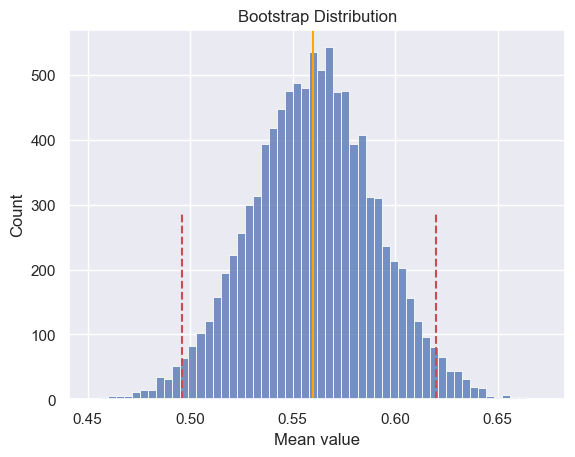

In [83]:
# Visualize the bootstrapped distribution
distribution = bootstrap_ci.bootstrap_distribution
bins = 56
sns.histplot(distribution, bins=bins);
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value')
# show mean and confidence intervals
plt.axvline(np.mean(toss), 0, 1, c='orange', linestyle='-')
ci = bootstrap_ci.confidence_interval
plt.axvline(ci[0], 0, 0.5, c='r', linestyle='--')
plt.axvline(ci[1], 0, 0.5, c='r', linestyle='--')
plt.show()

A bootstrap histogram is an effective visualization for understanding the statistics and expected values. In the plot above, the orange vertical line is the mean from the actual measurement, but it is easy to see all the other possible mean values. Additionally, the red vertical dashed lines represent the bounds for the 95% confidence interval and all mean values outside of the red vertical lines represent results that can be considered statistically significant.

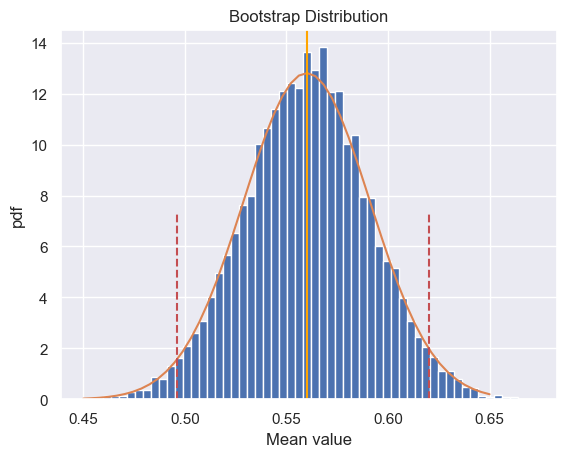

In [84]:
# Same plot with normal distribution overlaid
mean_sample = np.mean(toss)
x = np.linspace(0.45, 0.65)
pdf = stats.norm.pdf(x, loc=mean_sample, scale=bootstrap_ci.standard_error)
plt.hist(distribution, bins=bins, density=True);
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value')
plt.plot(x, pdf)
plt.xlabel('Mean value')
plt.ylabel('pdf')
plt.axvline(np.mean(toss), 0, 1, c='orange', linestyle='-')
plt.axvline(ci[0], 0, 0.5, c='r', linestyle='--')
plt.axvline(ci[1], 0, 0.5, c='r', linestyle='--')
plt.show()

For extra practice, let's calculate the bootstrapped confidence intervals manually for comparison.

In [85]:
np.random.seed(seed=42)
toss_mean = []
for _ in range(9999):
    sample_mean = np.random.choice(toss, size=len(toss), replace=True).mean()
    toss_mean.append(sample_mean)

ci_low = np.quantile(toss_mean, 0.025) 
ci_high = np.quantile(toss_mean, 0.975)
print(ci_low, ci_high)

0.5 0.62


As expected, the result of manually computing the bootstrapped confidence intervals is within three decimal places of the result from scipy's bootstrap method.

Besides confidence intervals, p-values are commonly used and can be calculated form bootstrapping. The general procedure is:
1. Calculate the statistic (mean in this case) for the original data
2. Shift the original data by some offset such that the statistic is equal to that of the null hypothesis
3. Bootstrap the shifted dataset, which represents a true null hypothesis
4. Use the bootstrapped distribution to calculate the p-value for observing the original statistical value (from step 1) or values more extreme.

In [86]:
null_mean = 0.5
# mean of the original data
toss_mean = np.mean(toss)
offset = toss_mean - null_mean
print(f'Offset value: {offset}')
# dataset representing true null hypothesis
toss_null = toss - offset

Offset value: 0.06000000000000005


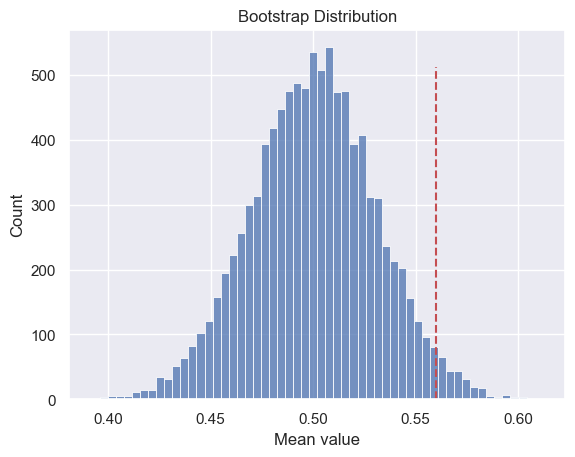

In [87]:
bootstrap_ci = stats.bootstrap((toss_null,), np.mean, confidence_level=0.95,
                               n_resamples=9999, random_state=42, 
                               method='BCa')

# Visualize the bootstrapped distribution
distribution = bootstrap_ci.bootstrap_distribution
bins = 56
sns.histplot(distribution, bins=bins);
plt.title('Bootstrap Distribution')
plt.xlabel('Mean value')
plt.axvline(toss_mean, 0, 0.9, c='r', linestyle='--');

Histogram shows the distribution for a fair coin. Red dotted line represents the observed mean value from the original dataset.

In [88]:
# Probability of observing the original mean value or more extreme
extreme_counts = ((distribution > (null_mean + offset)).sum() +
                  (distribution < (null_mean - offset)).sum())
p_value = extreme_counts / len(distribution)
print(f'p-value: {p_value:.4f}')

p-value: 0.0566


The p-value is greater than 0.5, thus we *fail to reject* the null hypothesis that the coin is fair. This matches the previous result using confidence intervals as expected.